In [71]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [72]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [74]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [75]:
words

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'has',
 'also',
 'been',
 'taken',
 'up',
 'as',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'defined',
 'anarchists',
 'the',
 'word',
 'anarchism',
 'is',
 'derived',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'as',
 'a',
 'political',
 'philosophy',
 'is',
 'the',
 'belief',
 'that',
 'rulers',
 'are',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolished',
 'although',
 'there',
 'are',
 'differing',
 '

In [76]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0 
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  


Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [77]:
dictionary['the']

1

In [78]:
dictionary['anarchism']

5234

In [79]:
reverse_dictionary[1]

'the'

In [80]:
data

[5234,
 3081,
 12,
 6,
 195,
 2,
 3134,
 46,
 59,
 156,
 128,
 742,
 477,
 10572,
 134,
 1,
 27350,
 2,
 1,
 103,
 855,
 3,
 1,
 15068,
 0,
 2,
 1,
 151,
 855,
 3581,
 1,
 195,
 11,
 191,
 59,
 5,
 6,
 10713,
 215,
 7,
 1325,
 105,
 455,
 20,
 59,
 2732,
 363,
 7,
 3673,
 1,
 709,
 2,
 372,
 27,
 41,
 37,
 54,
 540,
 98,
 12,
 6,
 1424,
 2758,
 19,
 568,
 687,
 7089,
 1,
 248,
 5234,
 11,
 1053,
 28,
 1,
 321,
 249,
 44612,
 2878,
 793,
 187,
 5234,
 12,
 6,
 201,
 603,
 11,
 1,
 1135,
 20,
 2622,
 26,
 8984,
 3,
 280,
 32,
 4148,
 142,
 60,
 26,
 6438,
 4187,
 2,
 154,
 33,
 363,
 5234,
 37,
 1138,
 7,
 448,
 345,
 1819,
 20,
 4861,
 1,
 6754,
 2,
 7574,
 1775,
 567,
 1,
 94,
 1,
 248,
 11065,
 12,
 52,
 7089,
 90,
 27,
 271,
 38,
 5949,
 4862,
 20300,
 29,
 0,
 42,
 318,
 6,
 25637,
 528,
 7574,
 372,
 5,
 259,
 2,
 154,
 26,
 1207,
 12,
 7574,
 201,
 1577,
 3,
 15201,
 333,
 1775,
 7089,
 4861,
 345,
 765,
 161,
 407,
 5691,
 756,
 2,
 4106,
 1132,
 4332,
 1537,
 3,
 568,
 8118,
 99

In [81]:
count

[['UNK', 418391],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644),
 ('is', 183153),
 ('as', 131815),
 ('eight', 125285),
 ('for', 118445),
 ('s', 116710),
 ('five', 115789),
 ('three', 114775),
 ('was', 112807),
 ('by', 111831),
 ('that', 109510),
 ('four', 108182),
 ('six', 102145),
 ('seven', 99683),
 ('with', 95603),
 ('on', 91250),
 ('are', 76527),
 ('it', 73334),
 ('from', 72871),
 ('or', 68945),
 ('his', 62603),
 ('an', 61925),
 ('be', 61281),
 ('this', 58832),
 ('which', 54788),
 ('at', 54576),
 ('he', 53573),
 ('also', 44358),
 ('not', 44033),
 ('have', 39712),
 ('were', 39086),
 ('has', 37866),
 ('but', 35358),
 ('other', 32433),
 ('their', 31523),
 ('its', 29567),
 ('first', 28810),
 ('they', 28553),
 ('some', 28161),
 ('had', 28100),
 ('all', 26229),
 ('more', 26223),
 ('most', 25563),
 ('can', 25519),
 ('been', 25383),
 ('such', 24413),
 ('many', 

In [82]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'a', 'term', 'of', 'term', 'as', 'originated']


In [83]:
batch_size = 128
embedding_size = 128 
skip_window = 1 
num_skips = 2
valid_size = 16 
valid_window = 100
window = 16
valid_examples = np.array(random.sample(range(window), valid_size))
#it will generate first 16 words from count variable in random sequence
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
 
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [84]:
num_steps = 100000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0

    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.175106
Nearest to as: paradox, oxidised, nesting, tubular, unworkable, rehoboam, skiers, swapping,
Nearest to two: necessity, levitt, ezekiel, wreckin, ins, gps, thunderbirds, bailiwick,
Nearest to s: deo, companies, particularly, jenkins, blaise, goldbach, primeval, maori,
Nearest to in: kushans, mills, patrons, austere, lamia, passover, fellows, overhead,
Nearest to to: hyperion, borrelly, pray, xinjiang, mikvah, teeth, pretence, sappho,
Nearest to of: bale, booths, adolfo, eero, slidell, ducati, heero, marlene,
Nearest to nine: consumed, sarcophagus, bowls, junit, sergei, tyrannical, dmz, checksum,
Nearest to is: euclidean, kilocalories, athlete, trustedbsd, kindred, mckellen, monads, grantham,
Nearest to for: plugboard, mauryan, philo, octets, rushing, dispersed, marshlands, adult,
Nearest to a: presidential, funakoshi, omnipotence, tome, resuming, marginally, caucasus, marle,
Nearest to one: arianespace, taichi, decaying, subtype, emilio, luk,

Average loss at step 58000: 3.394542
Average loss at step 60000: 3.396025
Nearest to as: marquee, bounds, when, stool, lacrosse, gabriele, echelon, peroxides,
Nearest to two: four, one, three, five, six, eight, seven, nine,
Nearest to s: flippers, experimenting, underwent, underdeveloped, rudi, solutes, whose, backplane,
Nearest to in: during, throughout, within, of, between, since, until, usaid,
Nearest to to: hyperion, exons, would, for, will, borrelly, may, lalor,
Nearest to of: in, for, including, eastbound, from, watercolor, like, utr,
Nearest to nine: eight, six, seven, four, five, three, zero, one,
Nearest to is: was, are, has, be, although, contains, hazel, annotation,
Nearest to for: of, to, including, although, if, while, jesuit, maeshowe,
Nearest to a: the, another, this, any, shutter, saber, superoxide, every,
Nearest to one: two, six, four, eight, three, seven, five, nine,
Nearest to the: their, its, a, this, some, reconsider, these, generalitat,
Nearest to eight: nine, si

In [85]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

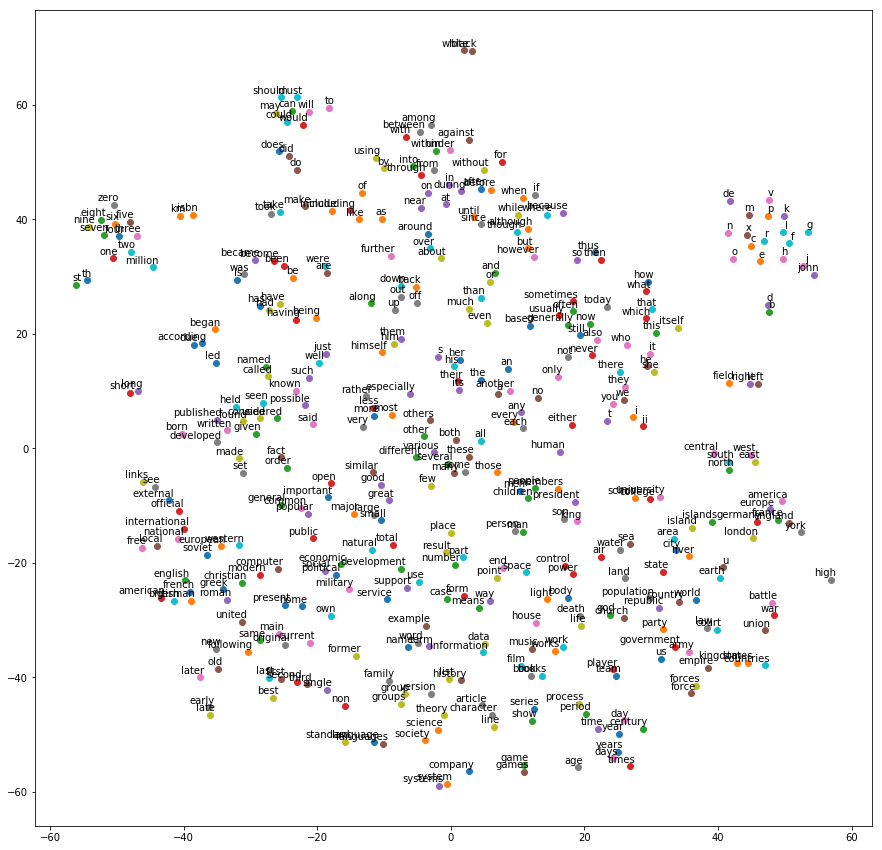

In [86]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)